# Graduate Project of CNN Regression version 4.1 - PSO-CNN

## Initialize machine learning library

In [60]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [61]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [62]:
features = pd.read_csv("/home/seb/Project/BEng-Graduate/data/data.csv", header=None)
features = features.transpose()
# features = data.values.T.astype(np.float32)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,500,501,502,503,504,505,506,507,508,509
0,70.0,200.0,300.0,28.801196,81.105366,6125.0,5690.0,6560.0,870.0,-120.782809,...,-118.949780,-118.499691,-118.020283,-117.503018,-116.936596,-116.305609,-115.588315,-114.752730,-113.749309,-112.495888
1,70.0,200.0,400.0,2.517709,47.612011,3860.0,3840.0,3880.0,40.0,-121.070769,...,-116.630247,-116.579676,-116.529680,-116.480227,-116.431285,-116.382825,-116.334820,-116.287244,-116.240073,-116.193283
2,70.0,200.0,500.0,3.068820,63.245190,3945.0,3920.0,3970.0,50.0,-121.322709,...,-113.516857,-113.319928,-113.096880,-112.840765,-112.541882,-112.186250,-111.752916,-111.208943,-110.499310,-109.524470
3,70.0,200.0,600.0,5.874144,55.115136,4050.0,4000.0,4100.0,100.0,-121.477196,...,-108.600004,-104.475919,-92.225585,-111.170745,-123.172305,-140.835187,-127.837068,-124.087345,-122.231465,-121.097501
4,70.0,200.0,700.0,-123.202804,67.654798,3635.0,4160.0,3110.0,-1050.0,-121.156614,...,-116.668022,-116.650467,-116.633328,-116.616634,-116.600387,-116.584503,-116.569146,-116.554043,-116.539304,-116.524892


Check data shape

In [63]:
print("data dimension:", features.shape)

data dimension: (392, 510)


### Draw original feature-describing histograms

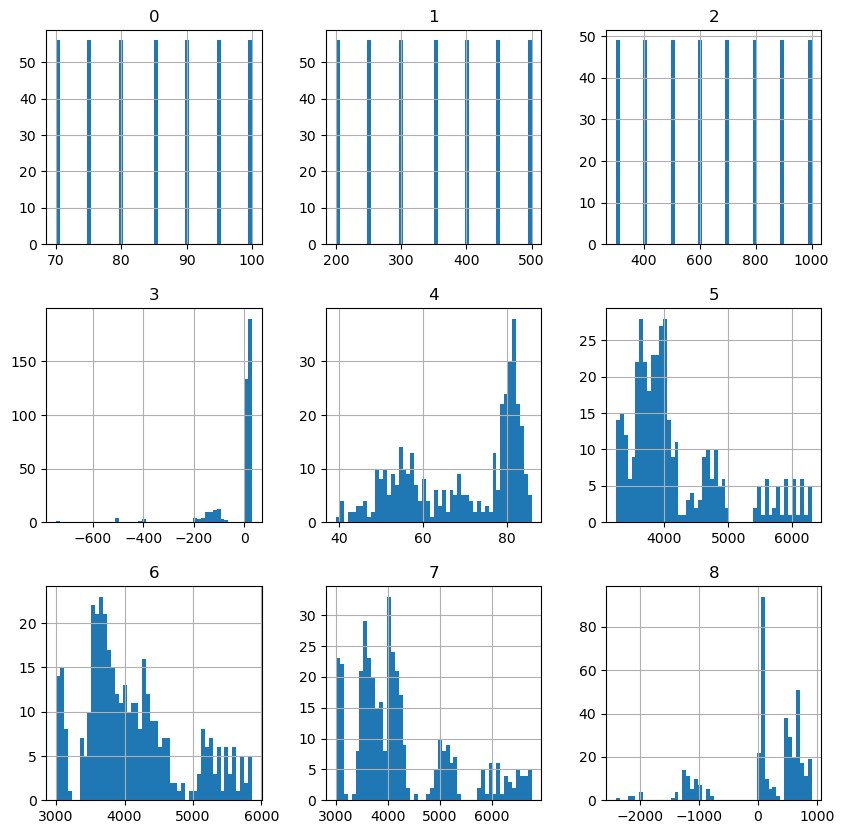

In [64]:
fea = features.iloc[:, :9]
fea.hist(bins=50, figsize=(10,10))
plt.show()

### Set label and transform it into a nparray

In [65]:
labels = np.array(features.iloc[:,9:])
features = np.array(features.iloc[:, :9])
features.shape

(392, 9)

## Exploratory Data Analysis

### Show the variation of respective features

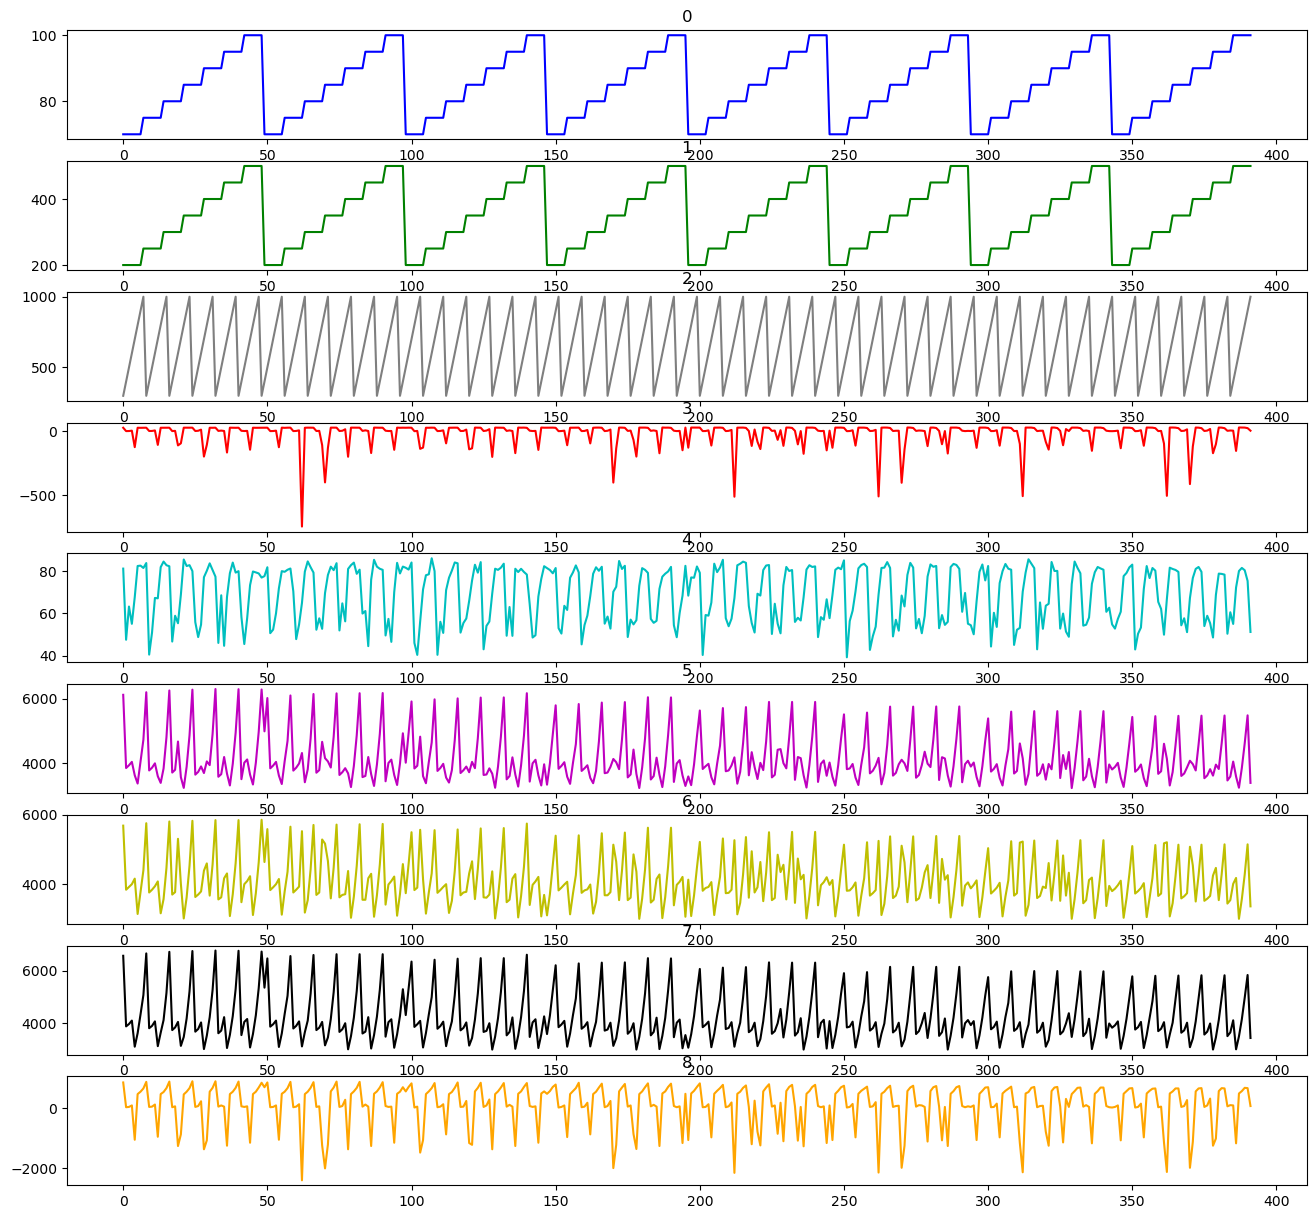

In [66]:
plt.figure(figsize=(16,15))
color = ['b', 'g', '#7f7f7f', 'r', 'c', 'm', 'y', 'k', '#FFA500']
for i in range(9):
  plt.subplot(9,1, i+1)
  a, = plt.plot(features[:,i],color= color[i])
  plt.title(i)

plt.show()

### Data standardization using sklearn

In [67]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
input_features = preprocessing.StandardScaler().fit_transform(features)
input_labels = preprocessing.StandardScaler().fit_transform(labels)
input_features[0]

array([-1.5       , -1.5       , -1.52752523,  0.47353794,  0.91441986,
        2.55646587,  2.22862805,  2.44093019,  1.07199055])

### Show histograms of standardized-features

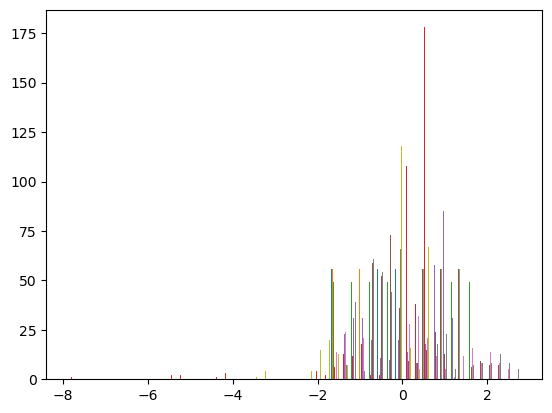

In [68]:
plt.hist(input_features, bins=50)
plt.show()

## Split data set into training and validating

In [69]:
x_train, x_val, y_train, y_val = train_test_split(input_features, input_labels, train_size = 0.8, shuffle = True, random_state = 2019)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 9, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32).reshape(-1, 9, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

check set tpye

In [70]:
print(type(x_train))
print(type(x_train_tensor))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


## Constract Convolutional Neural Network

### Import torch libraries

In [71]:
import torch.nn as nn
from torch.nn import Conv1d 
from torch.nn import MaxPool1d 
from torch.nn import Flatten 
from torch.nn import AvgPool1d
from torch.nn import BatchNorm1d
from torch.nn import Linear 
from torch.utils.data import DataLoader, TensorDataset 
from pyswarm import pso
import torch.optim as optim
import torch.nn.functional as F

### Define Hyper-parameters and set dataloader

In [72]:
input_size = 9
output_size = 501
num_epochs = 100
batch_size = 32

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Set up CNN module

In [73]:
class CNNRegressor(nn.Module):
    def __init__(self, inputs, outputs):
        super(CNNRegressor, self).__init__()
        self.inputs = inputs
        self.outputs = outputs

        # Convolution Sequence 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                inputs, 
                32, 
                kernel_size = 3, 
                padding = 1
            ),
            nn.ReLU()
        )

        # Convolution Sequence 2 with Batch Normalization and AP
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 128),
            nn.ReLU()
        )

        # Convolution Sequence 3 with 3 convolutional layers
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(num_features = 256),
            nn.ReLU()
        )

        # Convolution Sequence 4 with flatten and FC layers
        self.conv4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU()
        )

        self.out = nn.Linear(512, outputs)

    # Forward function
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # print("Before Flatten: ", x.shape)
        x = self.conv4(x)
        # print("After Flatten: ", x.shape)
        x = self.out(x)
        return x

### Training CNN model

In [74]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device='cpu'):
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return avg_val_loss  

## Finding best parameters using PSO

In [75]:
def pso_objective(params):
    lr, batch_size = params
    batch_size = int(batch_size)

    model = CNNRegressor(input_size, output_size)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    final_val_loss = train_model(model, train_loader, val_loader, optimizer, num_epochs=10)
    return final_val_loss

In [81]:
# PSO_optimizer
def optimize_hyperparameters():
    lb = [1e-5, 16]  
    ub = [1e-2, 128]  

    best_params, _ = pso(pso_objective, lb, ub, swarmsize=10, maxiter=5)
    best_lr, best_batch_size = best_params
    best_batch_size = int(best_batch_size)

    print(f"Best lr: {best_lr}, best batch_size: {best_batch_size}")
    return best_lr, best_batch_size

best_lr, best_batch_size = optimize_hyperparameters()

Epoch [1/10], Train Loss: 0.9450, Val Loss: 0.9558
Epoch [2/10], Train Loss: 0.8262, Val Loss: 0.9322
Epoch [3/10], Train Loss: 0.7425, Val Loss: 0.8901
Epoch [4/10], Train Loss: 0.6619, Val Loss: 0.8017
Epoch [5/10], Train Loss: 0.6172, Val Loss: 0.6463
Epoch [6/10], Train Loss: 0.5988, Val Loss: 0.6056
Epoch [7/10], Train Loss: 0.5783, Val Loss: 0.6061
Epoch [8/10], Train Loss: 0.5302, Val Loss: 0.5804
Epoch [9/10], Train Loss: 0.5147, Val Loss: 0.5343
Epoch [10/10], Train Loss: 0.5293, Val Loss: 0.5775
Epoch [1/10], Train Loss: 0.9504, Val Loss: 0.9221
Epoch [2/10], Train Loss: 0.8774, Val Loss: 0.8353
Epoch [3/10], Train Loss: 0.7863, Val Loss: 0.7617
Epoch [4/10], Train Loss: 0.7107, Val Loss: 0.6345
Epoch [5/10], Train Loss: 0.6884, Val Loss: 0.6417
Epoch [6/10], Train Loss: 0.7168, Val Loss: 0.6826
Epoch [7/10], Train Loss: 0.6767, Val Loss: 0.6192
Epoch [8/10], Train Loss: 0.6418, Val Loss: 0.5395
Epoch [9/10], Train Loss: 0.6099, Val Loss: 0.5546
Epoch [10/10], Train Loss: 0.5

### Train the model using best params

In [82]:
final_model = CNNRegressor(input_size, output_size)
final_optimizer = optim.Adam(final_model.parameters(), lr=best_lr)
train_model(final_model, train_loader, val_loader, final_optimizer, num_epochs=20)

Epoch [1/20], Train Loss: 0.9439, Val Loss: 0.8861
Epoch [2/20], Train Loss: 0.7981, Val Loss: 0.7763
Epoch [3/20], Train Loss: 0.7206, Val Loss: 0.7401
Epoch [4/20], Train Loss: 0.7436, Val Loss: 0.7497
Epoch [5/20], Train Loss: 0.7869, Val Loss: 0.8290
Epoch [6/20], Train Loss: 0.7592, Val Loss: 0.7196
Epoch [7/20], Train Loss: 0.6797, Val Loss: 0.6054
Epoch [8/20], Train Loss: 0.6169, Val Loss: 0.5330
Epoch [9/20], Train Loss: 0.5415, Val Loss: 0.5377
Epoch [10/20], Train Loss: 0.5800, Val Loss: 0.5067
Epoch [11/20], Train Loss: 0.5580, Val Loss: 0.5070
Epoch [12/20], Train Loss: 0.6271, Val Loss: 0.6838
Epoch [13/20], Train Loss: 0.5842, Val Loss: 0.5778
Epoch [14/20], Train Loss: 0.5445, Val Loss: 0.4842
Epoch [15/20], Train Loss: 0.5399, Val Loss: 0.5141
Epoch [16/20], Train Loss: 0.5222, Val Loss: 0.4785
Epoch [17/20], Train Loss: 0.4842, Val Loss: 0.4792
Epoch [18/20], Train Loss: 0.4615, Val Loss: 0.4715
Epoch [19/20], Train Loss: 0.4645, Val Loss: 0.4735
Epoch [20/20], Train 

0.5137813687324524

### Compare predictions to actural values

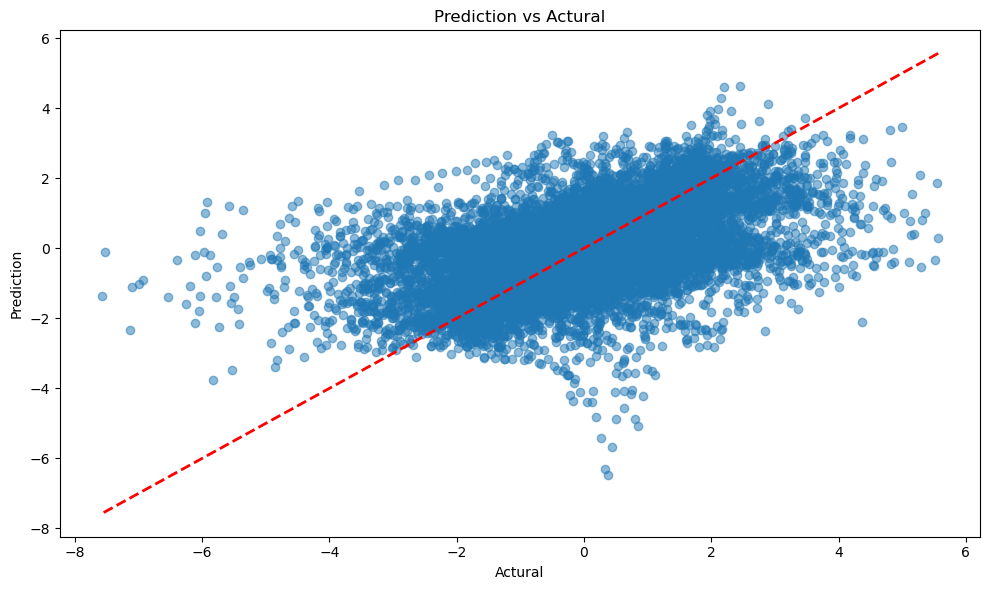

In [83]:
# Compare actural values with prediction
plt.figure(figsize = (10, 6))
plt.scatter(targets, predictions, alpha=0.5)
plt.plot([targets.max(), targets.min()], [targets.max(), targets.min()], 'r--', lw=2)

# Set graph config
plt.xlabel('Actural'); plt.ylabel('Prediction'); plt.title('Prediction vs Actural')
plt.tight_layout()
plt.show()

In [84]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(predictions, targets)
r2 = r2_score(predictions, targets)

print("MSE: ", mse)
print("R^2 :", r2)

MSE:  0.7295777
R^2 : -0.5504961609840393
